In [39]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from Helpers.Grae import get_GRAE_networks, BaseDataset


In [40]:

"""
This script pulls in one of Marshall's embeddings to validate how well it predicts the test points embedded by GRAE
"""

import sys
sys.path.append('/yunity/msn39/ADNI-Modeling-Dashboard')  # So we can get to the ADNI Dataset class
import ADNI_Dataset_Class


# Define the path to the pickle file
file_path = os.path.join('Datasets', 'Embeddings', 'your_pickle_file.pkl')

# Load the pickle files for the desired manifold alignment, embeddings, and dataset objects

# folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_Profile Variables 2025-01-03-06-35_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-54_Tau Variables 2025-02-20-21-22_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-42_2025-Feb-26-@-12-10"
# emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_Amyloid Variables 2025-02-21-16-50_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-18_Tau Variables 2025-02-20-21-22_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-42_2025-Feb-26-@-12-09"
# folder_name = os.listdir("/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/")[0]
# folder_name = "MASH_Seeds Variables A_LAST_DX_DX_bl_euclidean_selection-All_2025-Feb-20-@-02-43_Seeds Variables B_LAST_DX_DX_bl_euclidean_selection-All_2025-Feb-24-@-04-05_2025-Mar-02-@-09-06"
# emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/" + folder_name

folder_name = os.listdir("/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/")[0]
emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/" + folder_name

with open(emb_folder + '/class_object.pkl', 'rb') as file:
    mash_object = pickle.load(file)
with open(emb_folder + '/domain_object_1.pkl', 'rb') as file:
    domain_1_object = pickle.load(file)
with open(emb_folder + '/domain_object_2.pkl', 'rb') as file:
    domain_2_object = pickle.load(file)

In [41]:
dataset_data_1 = domain_1_object.data

In [42]:
domain_1_object.labels

34      1.0
35      1.0
36      1.0
37      1.0
38      1.0
       ... 
5317    1.0
5318    2.0
5319    2.0
5320    1.0
5322    2.0
Name: DIAGNOSIS, Length: 3687, dtype: float64

In [43]:
#domain_1_object.dataset_accuracy

In [44]:
X_train = mash_object.emb
y_train = pd.concat([domain_1_object.labels, domain_2_object.labels])  # Resets index after appending

# Train a Random Forest Classifier
embedding_based_model = RandomForestClassifier(n_estimators=100, random_state=42)
embedding_based_model.fit(X_train, y_train)

# print a not-meaningful evaluation of the embedding just to make sure we didn't pass something incorrectly
scores = cross_val_score(model, X_train, y_train, cv=3)

print(scores)


[0.64218213 0.64804469 0.63687151]


In [45]:
graeA, graeB = get_GRAE_networks(domain_1_object.data, domain_2_object.data, mash_object.emb, n_comp = 2, 
                  anchors = mash_object.known_anchors, labelsA = domain_1_object.labels, labelsB = domain_2_object.labels)

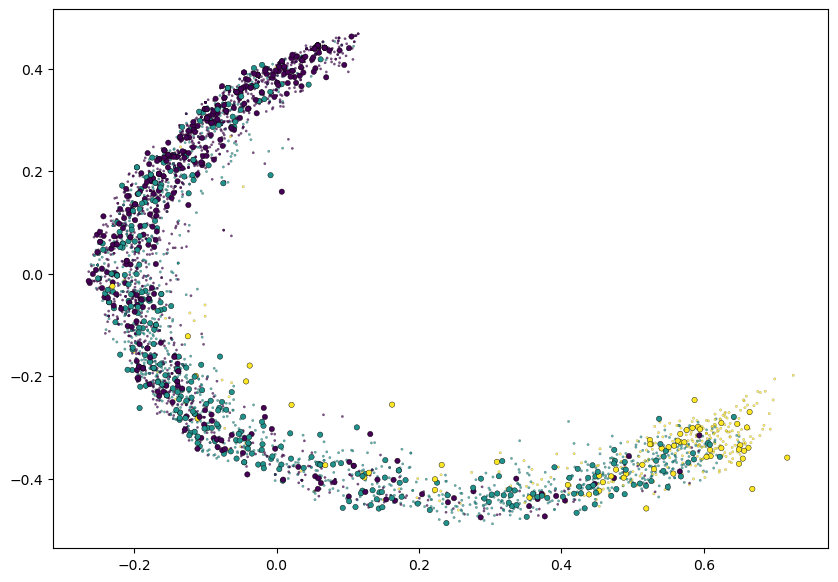

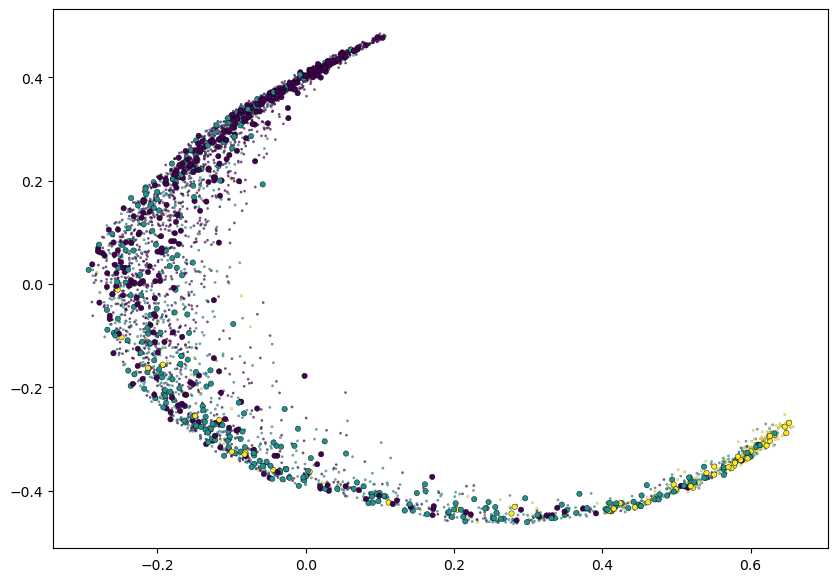

In [46]:
A_X_train_grae = BaseDataset(domain_1_object.data, np.array(domain_1_object.labels), split="none", split_ratio=0.8, random_state=42) #is there an error here
B_X_train_grae = BaseDataset(domain_2_object.data, np.array(domain_2_object.labels), split="none", split_ratio=0.8, random_state=42)

A_X_test_grae = BaseDataset(domain_1_object.test_data, np.array(domain_1_object.test_labels), split="none", split_ratio=0.8, random_state=42)
B_X_test_grae = BaseDataset(domain_2_object.test_data, np.array(domain_2_object.test_labels), split="none", split_ratio=0.8, random_state=42)

graeA.plot(A_X_train_grae, A_X_test_grae, cmap="viridis")
graeB.plot(B_X_train_grae, B_X_test_grae, cmap="viridis")

In [47]:
print(domain_1_object.type)
print(domain_2_object.type)

visit
visit


In [48]:
# See how accurate it is on the test points
new_embedded_points_A = graeA.transform(A_X_test_grae)
new_embedded_points_B = graeB.transform(B_X_test_grae)

# Predict on the test sets
predictions_A = embedding_based_model.predict(new_embedded_points_A)
predictions_B = embedding_based_model.predict(new_embedded_points_B)

# Evaluate accuracy
accuracy_A = accuracy_score(domain_1_object.test_labels, predictions_A)
accuracy_B = accuracy_score(domain_2_object.test_labels, predictions_B)


# Print all accuracy scores

domain_1_dataset_score = domain_1_object.dataset_accuracy
domain_1_distances_score = domain_1_object.distances_accuracy
domain_2_dataset_score = domain_2_object.dataset_accuracy
domain_2_distances_score = domain_2_object.distances_accuracy
manifold_oob = mash_object.get_scores(labels=y_train, n_jobs=-1)

print(f"Beginning Dataset A Score: {domain_1_dataset_score}")
print(f"Beginning Dataset B Score: {domain_2_dataset_score}")
print(f"Practical Test Accuracy A: {accuracy_A:.4f}")
print(f"Practical Test Accuracy B: {accuracy_B:.4f}")

Beginning Dataset A Score: 0.6347926267281107
Beginning Dataset B Score: 0.6293888166449935
Practical Test Accuracy A: 0.5977
Practical Test Accuracy B: 0.6009
